In [3]:
import os
import numpy as np
import pandas
import os
import skimage
from scipy import ndimage, signal
from skimage import exposure
import matplotlib.pyplot as plt
import glob
from skimage import io
import scipy
from scipy import signal
from skimage import feature
from tqdm import tqdm_notebook as tqdm
import json
from matplotlib_scalebar.scalebar import ScaleBar
import networkx as nx
import timeit

## Graph analysis

In [4]:
def _makeG(dic):
    
    G=nx.Graph()
    _Cells = _Sph['cells']
    G.add_nodes_from(_Cells.keys())
    
    for key in _Cells.keys():
    
        neighbours = _Cells[key]['neighbours']
    
        for node in neighbours:
    
            G.add_edge(key, node)
        
    return G

In [5]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\03072019\C1 tif\Spheroids'
dicName = glob.glob(path + r'\\' + '*.json')[0]

with open(dicName, "r") as read_file:
    _Sph = json.load(read_file)

In [6]:
G = _makeG(_Sph)

In [ ]:
nx.degree_assortativity_coefficient(G)

In [7]:
from community import community_louvain

partition = community_louvain.best_partition(G)

In [8]:
C = partition

In [11]:
A = nx.betweenness_centrality(G)

In [9]:
B = nx.clustering(G)

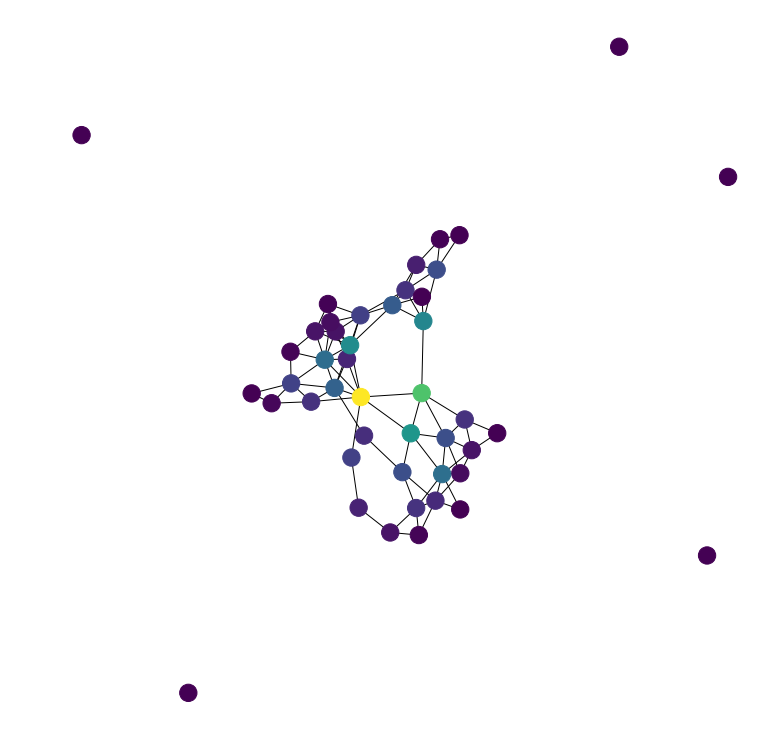

In [12]:
import re
import sys

import matplotlib.pyplot as plt
import networkx as nx

# draw with matplotlib/pylab
plt.figure(figsize=(10,10))

# with nodes colored by degree sized by population
node_color = [float(A[v]) for v in G]

nx.draw_spring(G, node_color=node_color,
        with_labels=False)

plt.show()

In [13]:
import collections

In [30]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\03072019\C1 tif\Spheroids'

df = pandas.DataFrame()
i = 0
    
for fileName in glob.glob(path + r'\\' + '*.json'):
    
    with open(dicName, "r") as read_file:
        _Sph = json.load(read_file)
        
    for key in _Sph['cells'].keys():
        
        df.loc[i, 'name'] = fileName
        df.loc[i, 'degree'] = _Sph['cells'][key]['degree']
        df.loc[i, 'clustering'] = _Sph['cells'][key]['clustering']
        df.loc[i, 'centrality'] = _Sph['cells'][key]['centrality']
        df.loc[i, 'state'] = _Sph['cells'][key]['state']
        i += 1

In [44]:
df

,name,degree,clustering,centrality,state
0,X:\Gustave\Experiments\Nuclei Segmentation\030...,1.0,0.000000,0.000000,Live
1,X:\Gustave\Experiments\Nuclei Segmentation\030...,6.0,0.800000,0.014316,Live
2,X:\Gustave\Experiments\Nuclei Segmentation\030...,4.0,1.000000,0.000000,Live
3,X:\Gustave\Experiments\Nuclei Segmentation\030...,6.0,0.800000,0.014316,Dead
4,X:\Gustave\Experiments\Nuclei Segmentation\030...,8.0,0.428571,0.162023,Live
5,X:\Gustave\Experiments\Nuclei Segmentation\030...,7.0,0.476190,0.065703,Live
6,X:\Gustave\Experiments\Nuclei Segmentation\030...,5.0,0.900000,0.001489,Live
7,X:\Gustave\Experiments\Nuclei Segmentation\030...,6.0,0.800000,0.002452,Live
8,X:\Gustave\Experiments\Nuclei Segmentation\030...,6.0,0.733333,0.011863,Live
9,X:\Gustave\Experiments\Nuclei Segmentation\030...,8.0,0.535714,0.058692,Live


C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


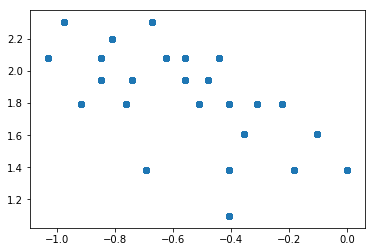

In [45]:
plt.scatter(np.log(df['clustering']), np.log(df['degree']))

C:\Users\gronteix\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


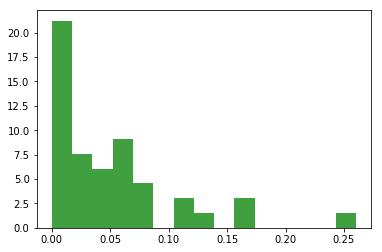

In [37]:
n, bins, patches = plt.hist(df['centrality'].values, 15, normed=1, facecolor='green', alpha=0.75)

In [ ]:
%matplotlib
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# What follows is a copy of the 3D plot example code.
# Data is randomly generated so there is no external data import.

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['x'], df['y'], df['z'])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_zlim(0,51)

plt.show()


from matplotlib_scalebar.scalebar import ScaleBar

for n in range(len(mask_img)):

    plt.subplot(111)
    plt.imshow(mask_img[n], cmap=plt.cm.gray, alpha = 0.8)
    plt.axis('off')
    
    scalebar = ScaleBar(0.000001, location = 'lower right') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)

    lf = df.loc[df['z'] == n]
    mf = df.loc[df['z'] == n-1]
    pf = df.loc[df['z'] == n+1]

    plt.plot(mf['y'], mf['x'], 'go', label = 'z = ' + str(n-1))
    plt.plot(lf['y'], lf['x'], 'yo', label = 'z = ' + str(n))
    plt.plot(pf['y'], pf['x'], 'ro', label = 'z = ' + str(n+1))

    plt.show()
    plt.legend()
    
    #plt.savefig(r'/Users/gustaveronteix/Desktop/Image Stack/filmstack/im_' + str(n) +'.png')
    plt.close()

In [ ]:
path = r'X:\Gustave\Experiments\Nuclei Segmentation\01072019\tif\\'
dicName = path + '\spheroid_00_00.json'

with open(dicName, "r") as read_file:
    _Sph = json.load(read_file)

import networkx as nx
G=nx.Graph()
_Cells = _Sph['cells']
G.add_nodes_from(_Cells.keys())
for key in _Cells.keys():
    
    neighbours = _Cells[key]['neighbours']
    
    for node in neighbours:
    
        G.add_edge(key, node)

centrality = []
eV = nx.degree_centrality(G)

import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

for key in _Cells.keys():
        
    centrality.append(eV[key])

plt.figure(figsize=(8, 8))

pos = nx.spring_layout(G)
im = nx.draw_networkx_nodes(G, pos, node_size=20, node_color = centrality, cmap=plt.cm.viridis)
nx.draw_networkx_edges(G, pos, alpha=0.4)

#legend
cbar = plt.colorbar(im)
cbar.set_label('Eigenvector centrality', rotation=270)
cbar.ax.get_yaxis().labelpad = 15

plt.axis('off')
#plt.savefig(path + '\\fig_58_5.png')
plt.show()


In [59]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def generate_random_3Dgraph(_Cells, zRatio, dCells, scale, seed=None):
    
    # Generate a dict of positions
    pos = {int(i): (scale*_Cells[i]['x'], scale*_Cells[i]['y'], scale*_Cells[i]['z']/zRatio) for i in _Cells.keys()}
    
    # Create random 3D network
    G = nx.random_geometric_graph(len(_Cells), dCells, pos=pos)
 
    return G

def network_plot_3D(G, angle, save=False):
 
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Get number of nodes
    n = G.number_of_nodes()
 
    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])
 
    # Define color range proportional to number of edges adjacent to a single node
    colors = [G.degree(i) for i in range(n)]
    cm = plt.cm.plasma
 
    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,8))
        ax = Axes3D(fig)
        

        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        
        for i,j in enumerate(G.edges()):
 
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.2)
            
        x = []
        y = []
        z = []
        nodeColor = []
        s = []
            
        for key, value in pos.items():
            x.append(value[0])
            y.append(value[1])
            z.append(value[2])
            nodeColor.append(colors[key])
            s.append(20+20*G.degree(key))
            
        # Scatter plot
        sc = ax.scatter(x, y, z, c=nodeColor, cmap=cm, s=s, edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted

    
    # Set the initial view
    ax.view_init(30, angle)
    fig.patch.set_facecolor((1.0, 1, 1))
    ax.set_facecolor((1.0, 1, 1))
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    plt.rc('grid', linestyle="-", color='black')
    
    ax.set_xlabel('X axis ($\mu m$)')
    ax.set_ylabel('Y axis ($\mu m$)')
    ax.set_zlabel('Z axis ($\mu m$)')
    ax.set_xlim(100, 250)
    ax.set_ylim(100, 250)
    #ax.set_zlim(50, 90)

 
    # Hide the axes
    #ax.set_axis_off()
    
    #legend
    axins = inset_axes(ax,
                   width="2%",  # width = 5% of parent_bbox width
                   height="50%",  # height : 50%
                   loc='upper right',
                    bbox_to_anchor=(0., 0., 0.95, 0.8),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    cbar = fig.colorbar(sc, cax=axins)
    cbar.set_label('Node degree', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
    return

In [60]:
#dicName = path + '\spheroid_00_00.json'

#with open(dicName, "r") as read_file:
#    _Sph = json.load(read_file)

import networkx as nx
G=nx.Graph()
_Cells = _Sph['cells']

In [61]:
G = generate_random_3Dgraph(_Cells, 1/5, 23, scale = 1/3, seed=None)

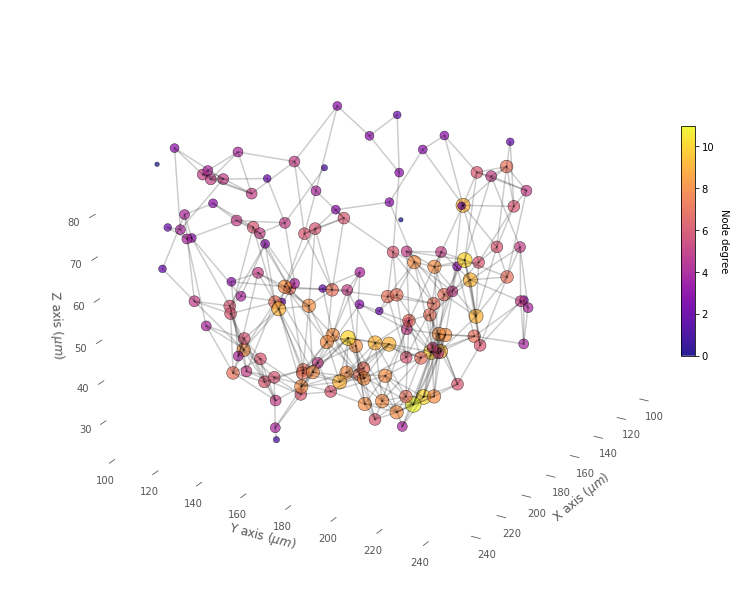

In [62]:
network_plot_3D(G,30, save=False)

plt.savefig(path + '\\3D_00_00.png')
plt.show()